c:\Users\Francesco\anaconda3\envs\env\Lib\site-packages\osgeo\gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


DEM opened successfully
DEM size: 3601 x 3601
(-80.00013888888888, 0.0002777777777777778, 0.0, -0.9998611111111111, 0.0, -0.0002777777777777778)
DEM NoData value: -32767.0
DEM min value: -57
DEM max value: 4143


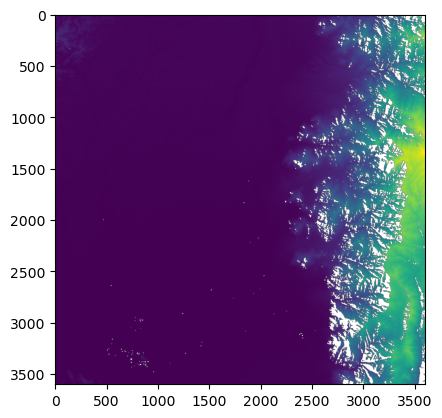

In [2]:
from osgeo import gdal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ee
import geemap
import os
import time

## DEM READING AND AOI CREATION
 
# Read a SRTM DEM on Guaranda, Bolivar Province (Ecuador)
dem_path = r"C:\Users\Francesco\Python\earthlab\data\Ecuador\DEM\s02_w080_1arc_v3.tif"
dem_img = gdal.Open(dem_path)

if dem_img is None:
    print("The DEM hasn't been read")
else:
    print("DEM opened successfully")
    print('DEM size:', dem_img.RasterXSize, 'x', dem_img.RasterYSize)

# Get the geotransform
dem_gt = dem_img.GetGeoTransform()
print(dem_gt)

# Get the band
dem_band = dem_img.GetRasterBand(1)

# Transform the raster in an array (numpy)
dem_cols = dem_img.RasterXSize
dem_rows = dem_img.RasterYSize
dem_np = dem_band.ReadAsArray(0, 0, dem_cols, dem_rows)

# Mask NoData
dem_nodata_value = dem_band.GetNoDataValue()
print('DEM NoData value:', dem_nodata_value)
dem_np = np.ma.masked_equal(dem_np, dem_nodata_value)

# Get min and max values in the array
print('DEM min value:', np.min(dem_np))
print('DEM max value:', np.max(dem_np))

# Show the DEM
plt.imshow(dem_np, vmin=0, vmax=4143)
plt.show()

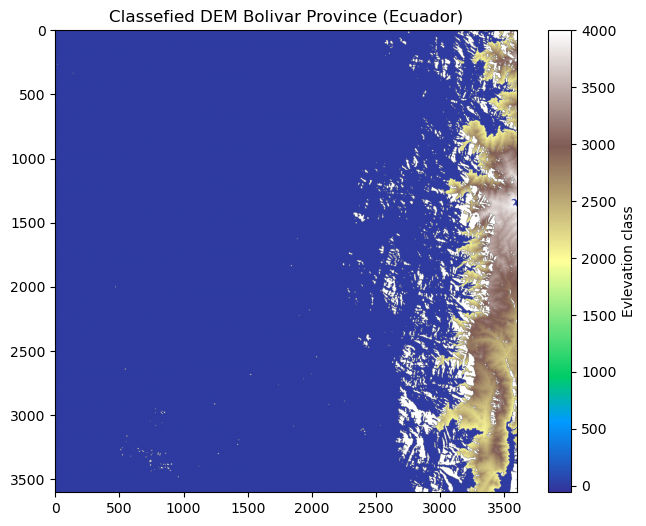

In [3]:
# Show the DEM classes <1000, 1000-2000, 3000-4000, >4000
dem_np_cl = dem_np.copy()

dem_np_cl[(dem_np_cl>0) & (dem_np_cl<=1000)] = 1
dem_np_cl[(dem_np_cl>1000) & (dem_np_cl<=2000)] = 2
dem_np_cl[(dem_np_cl>2000) & (dem_np_cl<=2000)] = 3
dem_np_cl[(dem_np_cl>4000)] = 4

plt.figure(figsize=(8, 6))
plt.imshow(dem_np_cl, cmap='terrain')
plt.colorbar(label='Evlevation class')
plt.title('Classefied DEM Bolivar Province (Ecuador)')
plt.show()

In [4]:
# Calculate the DEM bounding box
xmin = dem_gt[0]
ymin = dem_gt[3]
xmax = dem_gt[0] + dem_cols*dem_gt[1]
ymax = dem_gt[3] + dem_rows*dem_gt[5]
print("Bounding Box: ", f"xmin: {xmin}, ymin: {ymin}, xmax: {xmax}, ymax: {ymax}")

# Use Google Earth Engine
ee.Authenticate()
ee.Initialize()

# Create the aoi
aoi = ee.Geometry.Rectangle([xmin, ymin, xmax, ymax])

Bounding Box:  xmin: -80.00013888888888, ymin: -0.9998611111111111, xmax: -78.9998611111111, ymax: -2.000138888888889


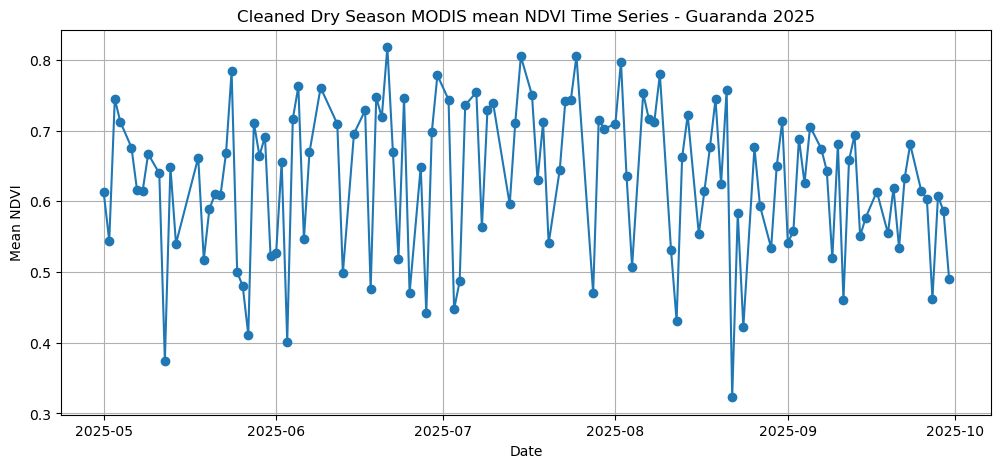

In [7]:
## MODIS NDVI COLLECTION

# Get the modis images for the dry season in the aoi
modis = ee.ImageCollection('MODIS/061/MOD09GA').filterBounds(aoi).filterDate('2025-05-01', '2025-10-01')

# QA Mask function
def mask_modis(image):

    state = image.select('state_1km')
    cloud_state = state.bitwiseAnd(0b11 << 0).rightShift(0)
    cloud_shadow = state.bitwiseAnd(0b1 << 2).rightShift(2)
    land_water = state.bitwiseAnd(0b111 << 3).rightShift(3)

    qc = image.select('QC_500m')
    modland = qc.bitwiseAnd(0b11 << 0).rightShift(0)

    mask = cloud_state.eq(0).And(cloud_shadow.eq(0)).And(land_water.eq(1)).And(modland.eq(0))

    return image.updateMask(mask)

# Create and add the NDVI band + valid pixels (pixels with ndvi!=0)
def add_ndvi(image):

    ndvi = image.normalizedDifference(['sur_refl_b02', 'sur_refl_b01']).rename('NDVI')

    valid_pixels = ndvi.mask().reduceRegion(
        reducer = ee.Reducer.count(),
        geometry = aoi,
        scale = 500,
        maxPixels = 1e13
    ).get('NDVI') # the reduceRegion() gives a ditionary as a result: {'ndvi': n.ofValidPixels}. The get('ndvi') takes the value of 'ndvi' from a dictionary and converts it in a number

    return image.addBands(ndvi).set('valid_pixels', valid_pixels) # the valid_pixels is stored as a metadata on the image

modis_clean_ndvi = modis.map(mask_modis).map(add_ndvi)

# Reduce to NDVI mean + valid pixels
def get_mean(image):
    
    mean_dict = image.select('NDVI').reduceRegion(reducer = ee.Reducer.mean(),
                                                  geometry = aoi,
                                                  scale = 500,
                                                  maxPixels = 1e13) # stats is a dictionary
    
    return ee.Feature(None, #no geometry
                      {'date': image.date().format('YYYY-MM-dd'),
                       'NDVI': mean_dict.get('NDVI'),
                       'valid_pixels': image.get('valid_pixels'),
                       'id': image.id()})

ndvi_fc = modis_clean_ndvi.map(get_mean)

# Convert to Pandas DataFrame
ndvi_list = ndvi_fc.getInfo()['features'] # pulls the data to the Python dictionary, accessing the list of features in the FeatureCollection

data = [(f['properties'].get('date'), # for each feature it extract the value of 'date', 'NDVI', ...
         f['properties'].get('NDVI'),
         f['properties'].get('valid_pixels'),
         f['properties'].get('id')) 
        for f in ndvi_list
        if f['properties'].get('NDVI') is not None]

ndvi_df = pd.DataFrame(data, columns=['date', 'NDVI', 'valid_pixels', 'id'])
ndvi_df['date'] = pd.to_datetime(ndvi_df['date'])
ndvi_df['NDVI'] = pd.to_numeric(ndvi_df['NDVI'])
ndvi_df['valid_pixels'] = pd.to_numeric(ndvi_df['valid_pixels'])
ndvi_df = ndvi_df.dropna().sort_values('date') # remove missing ndvi values and sort by date

# Filter by valid pixels (eliminate those images where the number of valid pixels is less than 30% of the maximum valid pixel number between the images). This makes the time series more reliable
max_valid = ndvi_df['valid_pixels'].max()
threshold = 0.3 * max_valid
ndvi_df = ndvi_df[ndvi_df['valid_pixels'] >= threshold]

# Outlier removal
Q1 = ndvi_df['NDVI'].quantile(0.25)
Q3 = ndvi_df['NDVI'].quantile(0.75)
IQR = Q3 - Q1
lower_outlier_limit = Q1 - 1.5*IQR
upper_outlier_limit = Q3 + 1.5*IQR

ndvi_clean = ndvi_df[(ndvi_df['NDVI'] >= lower_outlier_limit) & (ndvi_df['NDVI'] <= upper_outlier_limit)]

# Plot NDVI time series
plt.figure(figsize=(12, 5))
plt.plot(ndvi_clean['date'], ndvi_clean['NDVI'], marker='o', linestyle='-')
plt.title('Cleaned Dry Season MODIS mean NDVI Time Series - Guaranda 2025')
plt.xlabel('Date')
plt.ylabel('Mean NDVI')
plt.grid(True)
plt.show()